In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import collections

In [2]:
class Gridworld():

  def __init__(self, height, width, number_blocker):
    """
    A grid has a specific height and width, a specific number of blockers, an 
    agent that moves on the board and a reward associated with the agents 
    behaviour.
    """
    # Set board dimensions with given parameters, but at least 5x5
    self.height = height if height > 5 else 5
    self.width = width if width > 5 else 5

    # Create the board configuration with the given number of blockers, but at 
    # least 2 and at most 10 blockers
    self.number_blocker = number_blocker if 2 < number_blocker < 10 else 2 if number_blocker <= 2 else 10
    self.board, self.prob_states = self.create_board()

    # Initialize the agent at a fixed position (0,0) and no current reward (0)
    self.reward = 0
    self.agent = (0,0)


  def path_exists(self, grid_original, terminal_state_pos):
    """
    Tests for a specific board configuration, whether the agent is theoretically 
    able to reach the terminal state. Due to blockers, it could be the case that 
    this is not possible. Returns true if a path exists, else false.
    """
    grid = grid_original.copy()
    grid[grid == None] = 0
    n = len(grid)
    dirs = [(-1,0), (1,0), (0,1), (0,-1)]
    queue = collections.deque()
    queue.append([(0,0)])
    
    while queue:
      current_path = queue.popleft()
      last_cell_i = current_path[-1][0]
      last_cell_j = current_path[-1][1]
        
      for x,y in dirs:
        new_i = x + last_cell_i
        new_j = y + last_cell_j
            
        # Check if new cell is in grid
        if new_i < 0 or new_i >= n or new_j < 0 or new_j >= n:
          continue

        # Check if new cell is 'reachable' (only if it is not blocked, i.e. 
        # 'None' value)
        if grid_original[new_i][new_j] == None:
          continue
            
        # Check if new cell is already in path
        if (new_i, new_j) in current_path:
          continue
            
        # Add cell to current path
        current_path_copy = current_path.copy()
        current_path_copy.append((new_i, new_j))
        
        if new_i==terminal_state_pos[0] and new_j == terminal_state_pos[1]:
          return True
            
        queue.append(current_path_copy)

    return False

  def create_board(self):
    """
    Create board configurations. Blockers are initialized through null values 
    for the reward per position, negative rewards are for all non-goal available 
    states and a positive reward for the goal state.
    """
    # The board consists of a given number of blockers (None values), one tile 
    # with a positive reward, and all other tiles with a negative reward.
    board = [None] * self.number_blocker
    board += [1]
    board += [-0.5] * (self.width * self.height - self.number_blocker - 1)

    # Shuffle the board randomly
    np.random.shuffle(board)
    board = np.array(board).reshape(self.width, self.height)

    # If position where agent is initialized (=0,0) is None or 1, the position 
    # is reset to -0.5 and a -0.5 value is replaced with either None or 1
    if board[0,0] in [None, 1]:
      # Choose one position with -0.5 reward randomly
      neg_positions = np.array(np.where(board == -0.5)).T
      random_position = random.choice(neg_positions)

      # Swap positions
      board[0, 0], board[random_position[0], random_position[1]] = board[random_position[0], random_position[1]], board[0, 0]

    # Check if way is possible in current configuration, else re-initialize
    if self.path_exists(board, np.where(board == 1)):

      # Randomly generate three states that are probabilistic and save the 
      # coordinates
      neg_positions = np.array(np.where(board == -0.5)).T
      prob_states = np.array(random.sample(list(neg_positions[1:]), 3))

      return board, prob_states
    else:
      return self.create_board() # Continue until valid board state has been found

  def reset(self):
    """
    Resets the board to an initial state but keeps the original board size and 
    random blockers.
    """
    self.agent = (0,0) # reset agent to the initial state
    self.reward = 0 # reset the reward


  def action_valid(self, state, action):
    """
    Determines if given action is valid in given state.
    """
    new_position = np.array(self.agent)

    if action == 'up' or action == 0:
      new_position[0] = new_position[0] + 1
    elif action == 'down' or action == 1:
      new_position[0] = new_position[0] - 1
    elif action == 'left' or action == 2:
      new_position[1] = new_position[1] - 1
    elif action == 'right' or action == 3:
      new_position[1] = new_position[1] + 1
    else:
      print("Action {} not found!".format(action))

    available_positions = np.where(self.board)

    if np.any(np.all(new_position == (np.array(available_positions).T), axis=1)):
      return True, new_position
    else:
      return False, None


  def step(self, action):
    """
    Performs one step from the current state with a given action to achieve the
    next state. Allowed actions are up, down, left, right, but only within the 
    boundaries of the grid and depending on position of blockers.
    """
    action_options = ['up', 'down', 'left', 'right']
    assert action in action_options, "Non-existing action! Please choose a valid action ('up', 'down', 'left', 'right')."

    # Determine the future position of the agent
    new_position = np.array(self.agent)

    # Check if the current position is a probabilistic one
    if np.any(np.all(new_position == self.prob_states, axis=1)):

      #print('probabilistic')

      # With 70% probability, perform the desired action or another one with 
      # the other 30 equally distributed over the other possible actions
      possible_actions = np.array([ac for ac in action_options if self.action_valid(new_position, ac)[0]])
      probabilities = np.zeros_like(possible_actions)

      if len(possible_actions) > 1:

        probabilities[possible_actions == action] = 0.7
        probabilities[possible_actions != action] = round(0.3 / (len(probabilities) - 1), 2)
      
      else:

        probabilities[possible_actions == action] = 1.
        probabilities[possible_actions != action] = 0.

      action = np.random.choice(possible_actions, p=probabilities.astype(np.float32))

    # Determine the future position and only move agent if 
    # valid
    valid, new_position = self.action_valid(self.agent, action)
    #print(valid)
    assert valid, "Unallowed action, make sure to choose an action within the boundaries of the board and blockers."

    self.agent = new_position
    self.reward += self.board[new_position[0], new_position[1]]

    return new_position, self.board[new_position[0], new_position[1]]

  def visualize(self):
    """
    Visualizes the current state and prints the current return.
    """
    # Reachable tiles are white, blockers are shown in black, the terminal state 
    # (reward = 1) is green and the agent is displayed in red.
    plot_board = np.ones((self.board.shape[0], self.board.shape[1], 3))
    plot_board[self.board == None] = [0, 0, 0]
    plot_board[self.board == 1] = [0, 1, 0]
    for prob_state in self.prob_states:
      plot_board[prob_state[0], prob_state[1]] = [0.7, 0.85, 0.9]
    plot_board[self.agent[0], self.agent[1]] = [1, 0, 0]
    

    # Show visualization
    plt.title('Current return: ' + str(self.reward))
    plt.plot(0, 0, '-', color='red', label='Agent')
    plt.plot(0, 0, '-', color='green', label='Terminal state (Reward = 1)')
    plt.plot(0, 0, '-', color='black', label='Blockers')
    plt.plot(0, 0, '-', color='white', label='Reward = -0.5')
    plt.plot(0, 0, '-', color=[0.7, 0.85, 0.9], label='Probabilistic states')
    plt.imshow(plot_board.astype(np.float32), origin='lower')
    plt.legend(loc="upper right", bbox_to_anchor=(2., 1))
    plt.show()


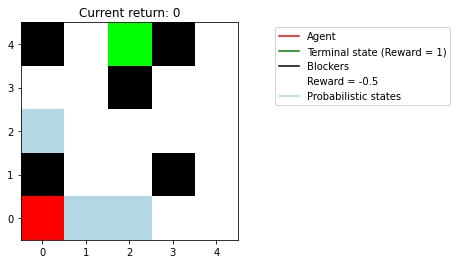

In [3]:
current = Gridworld(5, 5, 5)
current.visualize()

In [4]:
current.step('right')

(array([0, 1]), -0.5)

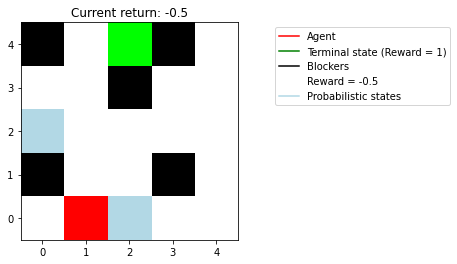

In [5]:
current.visualize()

### Tabular n-step SARSA

In [6]:
class Tab_SARSAN():
  """
  Tabular n-SARSA algorithm for a given n, stepsize (alpha), discount factor
  (gamma) and epsilon.
  """

  def __init__(self, n, alpha, gamma, epsilon):
    self.n = n
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon

    self.env = Gridworld(6, 6, 3)
    self.q_values = np.zeros((self.env.width, self.env.height, 4))


  def policy(self, state):
    """
    Epsilon-soft policy: Returns the best action (according to Q-values) with a
    probability of epsilon and explores other actions otherwise.
    """
    best_action = np.argmax(self.q_values[state[0]][state[1]])

    if random.random() > self.epsilon:
      while not self.env.action_valid(state, best_action)[0]:
        # penalize impossible actions
        self.q_values[state[0]][state[1]][best_action] = -100
        best_action = np.argmax(self.q_values[state[0]][state[1]])
      return best_action
    else:
      explr_action = random.randint(0, 3)
      while not self.env.action_valid(state, explr_action)[0]:
        explr_action = random.randint(0, 3)
      return explr_action


  def int_to_action(self, action_nr):
    """
    Maps action numbers to strings.
    """
    if action_nr == 0:
      return 'up'
    elif action_nr == 1:
      return 'down'
    elif action_nr == 2:
      return 'left'
    elif action_nr == 3:
      return 'right'
    else:
      print("Action was not recognized")


  def run(self, episodes=10, visualize=False):
    """
    Executes the n-SARSA algorithm for a given number of episodes.
    """

    for episode in range(episodes):

      if episode == 0:
        self.env.visualize()  

      print("EPISODE {}".format(episode))

      states = []
      actions = []
      rewards = []

      # initialize S
      current_state = self.env.agent
      states.append(current_state)
      # choose initial A
      current_action = self.policy(current_state)
      actions.append(current_action)

      T = float('inf')
      t = 0
      # just set t_updated to some start value
      t_updated = 0

      while t_updated != T - 1:
        if t < T:
          # perform action A and observe S' and R
          next_state, reward = self.env.step(self.int_to_action(current_action))
          states.append(next_state)
          rewards.append(reward)

          if visualize:
            self.env.visualize()
          
          # Stop if terminal state (goal) is reached
          if self.env.board[next_state[0]][next_state[1]] == 1:
            break
          else:
            # choose A'
            next_action = self.policy(next_state)
            actions.append(next_action)

        t_updated = t - self.n + 1

        if t_updated >= 0:
          G = 0
          for i in range(t_updated + 1, min(t_updated + self.n, T)):
            G += self.gamma ** (i - t_updated - 1) * rewards[i]
          
          if t_updated + self.n < T:
            G += self.gamma ** self.n + self.q_values[states[t_updated + self.n][0]][states[t_updated + self.n][1]][actions[t_updated + self.n]]
          self.q_values[states[t_updated][0]][states[t_updated][1]][actions[t_updated]] += self.alpha * (
                  G - self.q_values[states[t_updated][0]][states[t_updated][1]][actions[t_updated]])
        
        #current_state = next_state
        current_action = next_action

        t = t + 1

      self.env.reset()

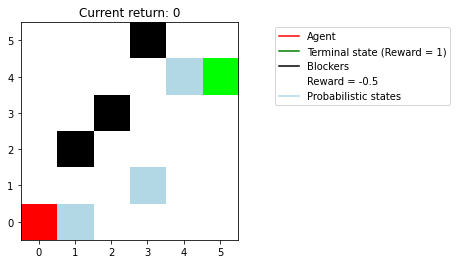

EPISODE 0
EPISODE 1
EPISODE 2
EPISODE 3
EPISODE 4
EPISODE 5
EPISODE 6
EPISODE 7
EPISODE 8
EPISODE 9
EPISODE 10
EPISODE 11
EPISODE 12
EPISODE 13
EPISODE 14
EPISODE 15
EPISODE 16
EPISODE 17
EPISODE 18
EPISODE 19
EPISODE 20
EPISODE 21
EPISODE 22
EPISODE 23
EPISODE 24
EPISODE 25
EPISODE 26
EPISODE 27
EPISODE 28
EPISODE 29
EPISODE 30
EPISODE 31
EPISODE 32
EPISODE 33
EPISODE 34
EPISODE 35
EPISODE 36
EPISODE 37
EPISODE 38
EPISODE 39
EPISODE 40
EPISODE 41
EPISODE 42
EPISODE 43
EPISODE 44
EPISODE 45
EPISODE 46
EPISODE 47
EPISODE 48
EPISODE 49
EPISODE 50
EPISODE 51
EPISODE 52
EPISODE 53
EPISODE 54
EPISODE 55
EPISODE 56
EPISODE 57
EPISODE 58
EPISODE 59
EPISODE 60
EPISODE 61
EPISODE 62
EPISODE 63
EPISODE 64
EPISODE 65
EPISODE 66
EPISODE 67
EPISODE 68
EPISODE 69
EPISODE 70
EPISODE 71
EPISODE 72
EPISODE 73
EPISODE 74
EPISODE 75
EPISODE 76
EPISODE 77
EPISODE 78
EPISODE 79
EPISODE 80
EPISODE 81
EPISODE 82
EPISODE 83
EPISODE 84
EPISODE 85
EPISODE 86
EPISODE 87
EPISODE 88
EPISODE 89
EPISODE 90
EPISODE 9

In [9]:
SARSA = Tab_SARSAN(1, 0.01, 0.99, 0.1)
SARSA.run(100, visualize=False)

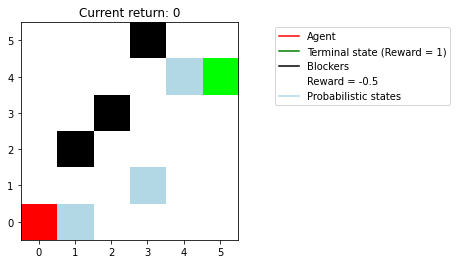

EPISODE 0


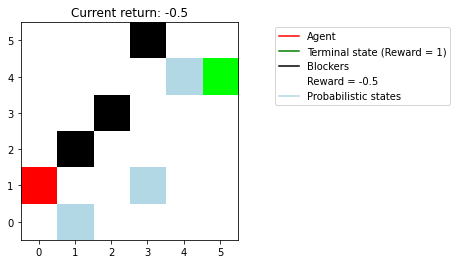

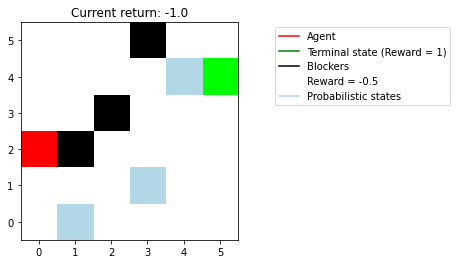

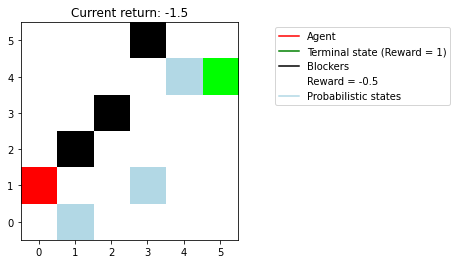

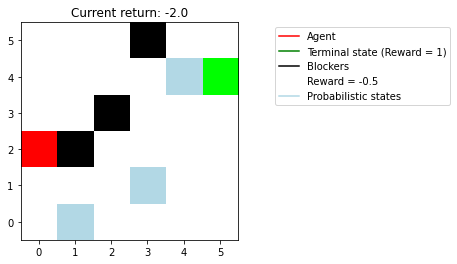

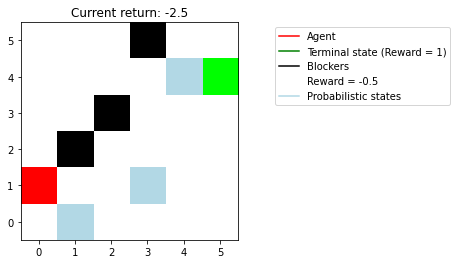

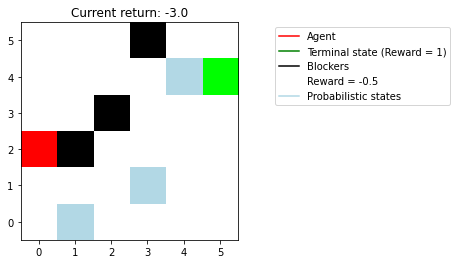

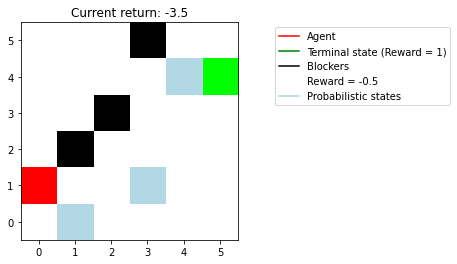

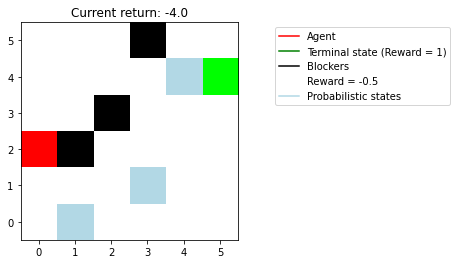

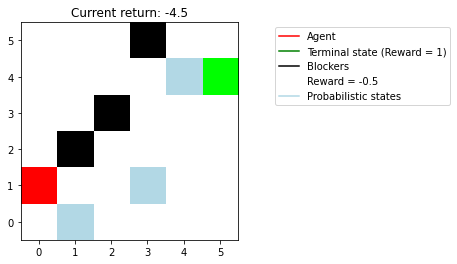

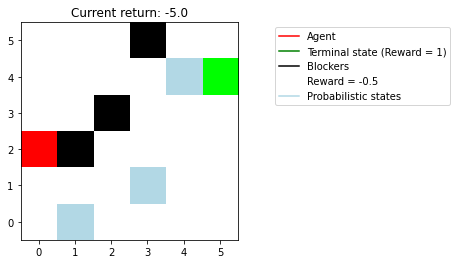

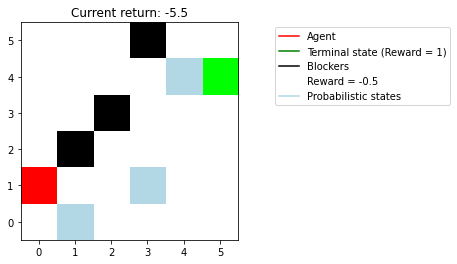

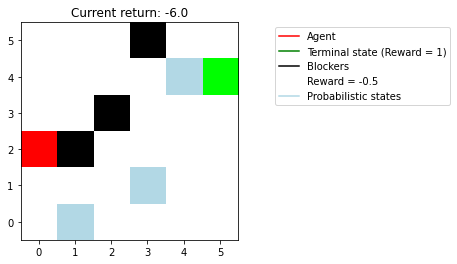

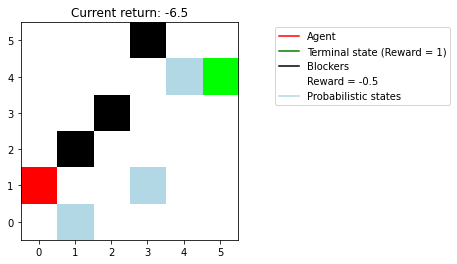

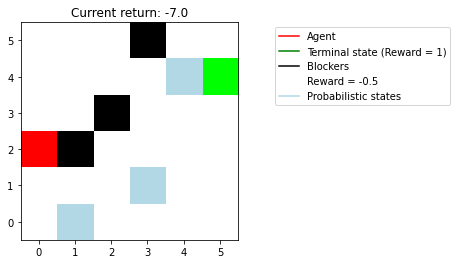

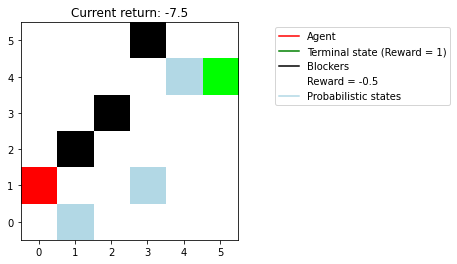

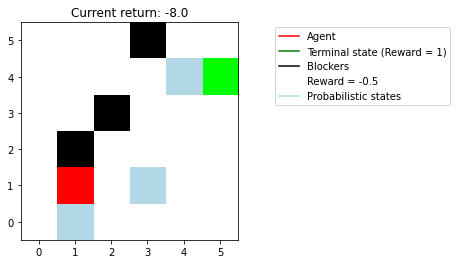

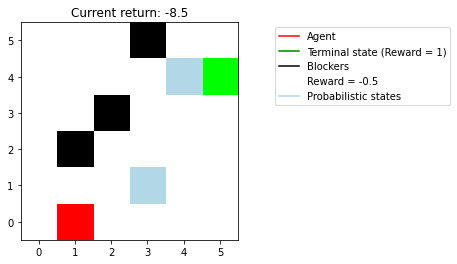

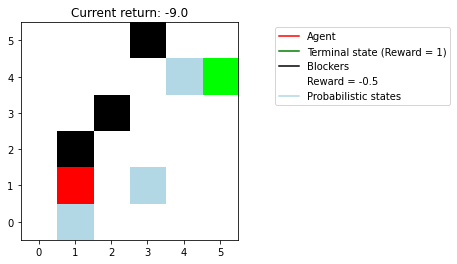

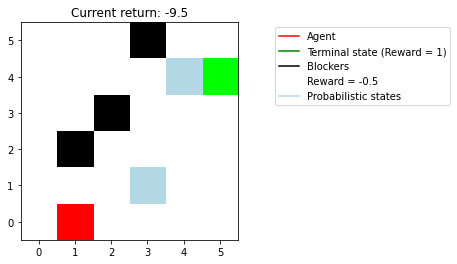

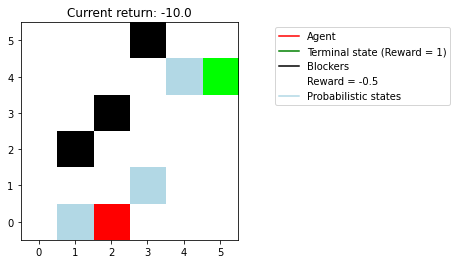

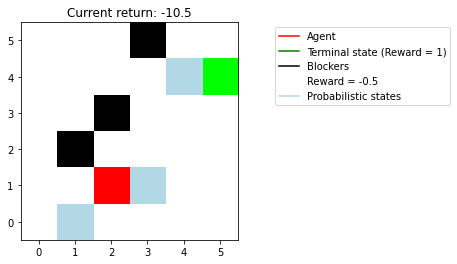

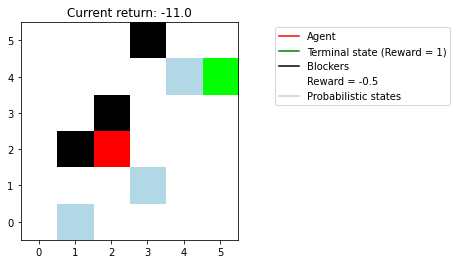

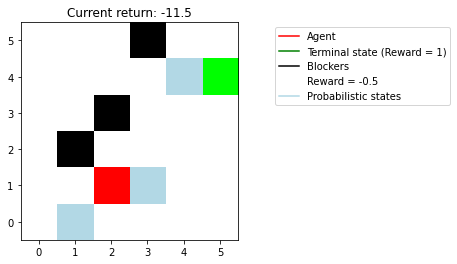

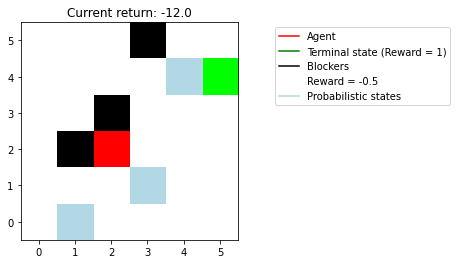

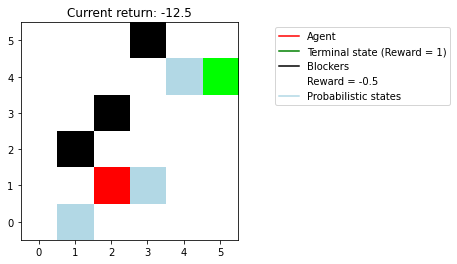

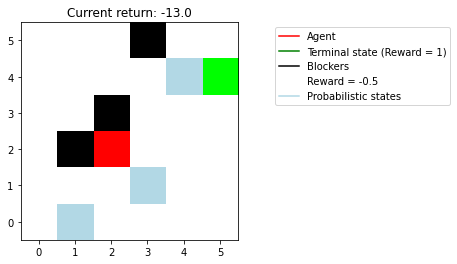

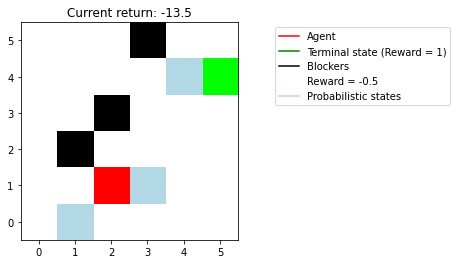

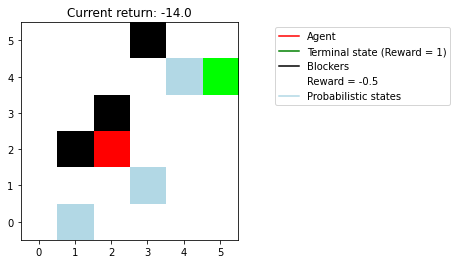

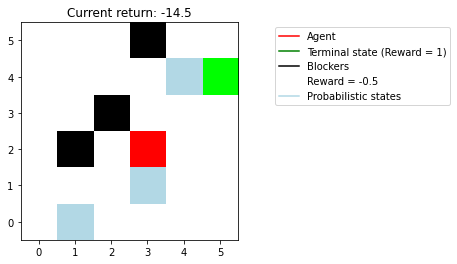

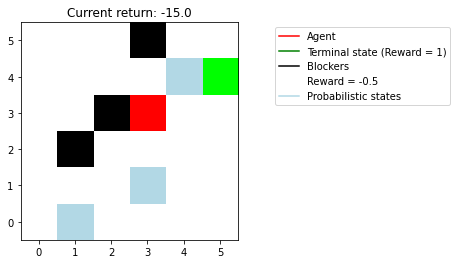

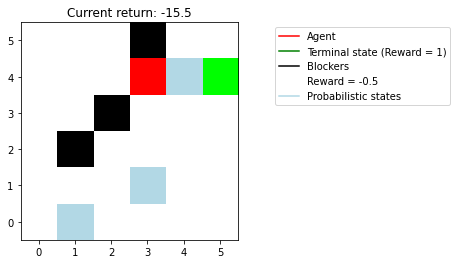

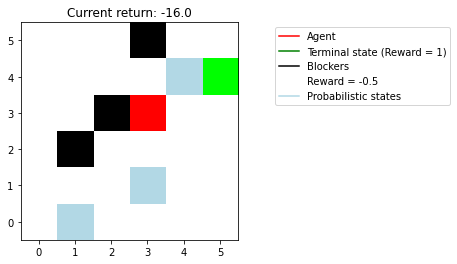

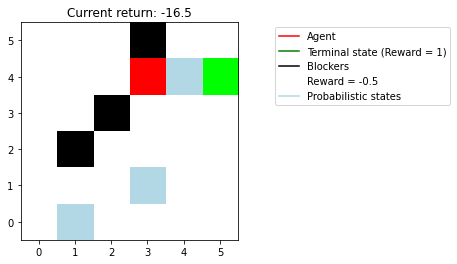

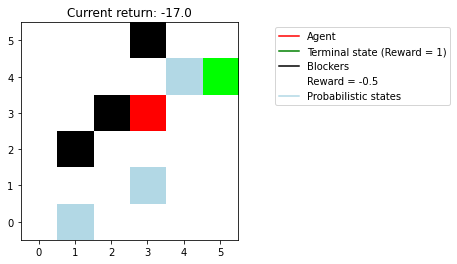

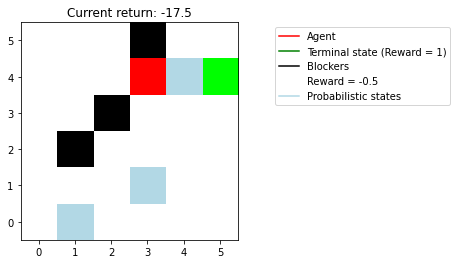

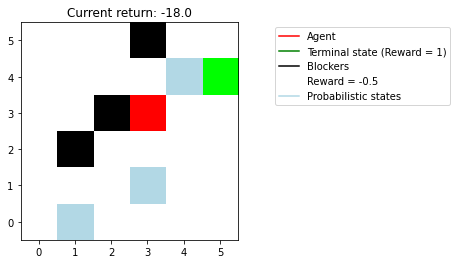

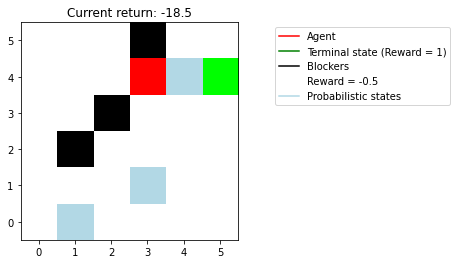

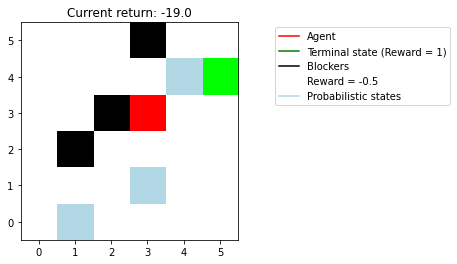

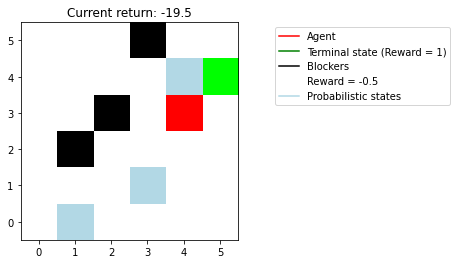

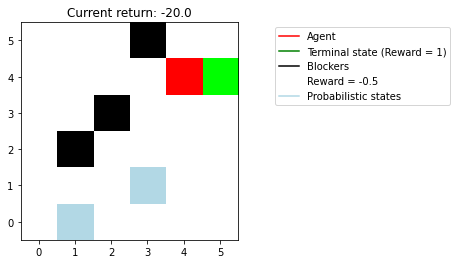

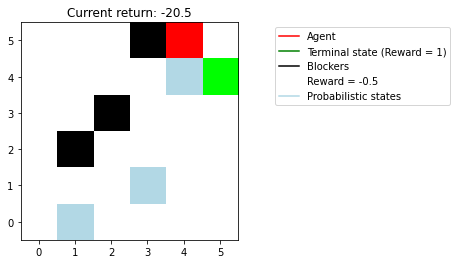

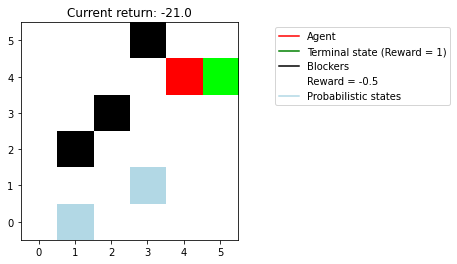

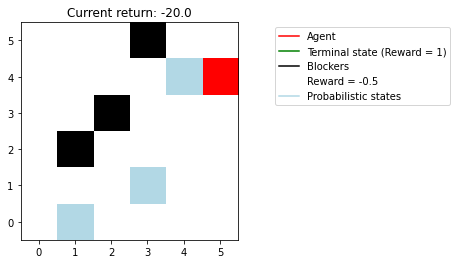

In [10]:
SARSA.run(1, visualize=True)